# Fall 2022 Data Science Intern Challenge
by Edward Moore – May 2022
***

## Question 1
Given some sample data, write a program to answer the following: __[click here to access the required data set](https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0)__

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.
1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.
1. What metric would you report for this data set?
1. What is its value?

### Results Summary
Based on the analysis below, I have provided responses to the three questions posed in this first exercise. Following this section, I have provided an in-depth analysis with detailed explanations to illustrate exactly how I arrived to the results. 
1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.
>The AOV of \\$3145.13 was calculated by averaging the *order_amount* column. This would be a great way to measure the AOV if the data was consistent and evenly distributed, however, this is not the case with the given data set. Since there are some extreme outliers in the data set, **a better way to evaluate this data is to first clean the data by removing outliers**. 
1. What metric would you report for this data set?
>For this data set, the metrics I would report are **average order value** (AOV) and **average total items per order**. I also see benefit in reporting the range (**min & max**) for both metrics. That being said, I would report those values after removing outliers and be sure to **report the outliers as special cases**. 
1. What is its value?
>Average order value: **\\$300.16** <br>
Order value range: **\\$90.00 - \\$1086.00** <br>
Average total items per order: **2** <br>
Total items per order range: **1 - 8** <br><br>
Special cases:<br>
>-  Shop 78 has an extremely high unit price of \\$25,725. They have 46 orders total with an average of 2 items per order. The number of items per order ranges from 1-6.
>-  Shop 42 has a unit price of \\$352, significantly higher than the other shops. They have 51 orders in total, 17 of which have 2000 items per order and an order amount of \\$704,000. The remaining 34 orders have an average of 2 items per order. The number of items per order ranges from 1-5.

### Analysis and Explanation
#### Acquiring the Data
Before diving into any analysis, we need to access the data set and save it in a pandas dataframe that I will call *`df`*. I made a copy of the Google Sheets data set and saved it to my own Google Drive in case any access is removed. I will be modifying the url to handle the sheet as a CSV file so I can write the data into a pandas dataframe directly using *`pd.read_csv`*, without having to download to my local drive. 

In [1]:
import pandas as pd

sheet_url = 'https://docs.google.com/spreadsheets/d/1l2TtMA5IwfTQAJ26dKQG-OpVxmbiLcpsAu0GIa4yf5o/edit#gid=0'
csv_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(csv_url)
df.head()

order_id  shop_id  user_id  order_amount  total_items payment_method  \
0         1       53      746           224            2           cash   
1         2       92      925            90            1           cash   
2         3       44      861           144            1           cash   
3         4       18      935           156            1    credit_card   
4         5       18      883           156            1    credit_card   

            created_at  
0  2017-03-13 12:36:56  
1  2017-03-03 17:38:52  
2   2017-03-14 4:23:56  
3  2017-03-26 12:43:37  
4   2017-03-01 4:35:11

#### Exploratory Data Analysis
First, let's check the datatypes to make sure they don't need to be changed.

In [2]:
df.dtypes

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object

We can see that the datatypes are approriate. 

Since each shop only sells one model of shoe, let's find the unit price for each shop and add it to our dataframe. Then, let's use *`.describe()`* to review a statistical summary of the data set. 

In [3]:
unit_price = df['order_amount']/df['total_items']
df['unit_price'] = unit_price

df.describe()

order_id      shop_id      user_id   order_amount  total_items  \
count  5000.000000  5000.000000  5000.000000    5000.000000   5000.00000   
mean   2500.500000    50.078800   849.092400    3145.128000      8.78720   
std    1443.520003    29.006118    87.798982   41282.539349    116.32032   
min       1.000000     1.000000   607.000000      90.000000      1.00000   
25%    1250.750000    24.000000   775.000000     163.000000      1.00000   
50%    2500.500000    50.000000   849.000000     284.000000      2.00000   
75%    3750.250000    75.000000   925.000000     390.000000      3.00000   
max    5000.000000   100.000000   999.000000  704000.000000   2000.00000   

         unit_price  
count   5000.000000  
mean     387.742800  
std     2441.963725  
min       90.000000  
25%      133.000000  
50%      153.000000  
75%      169.000000  
max    25725.000000

After adding the unit price per shop and reviewing the statistical summary of the data, there are some things that jump to my attention. 

Firstly, it is apparent that the AOV of \\$3145.13 was calculated by averaging the values in the column *order_amount*. If we review the distribution of *order_amount*, **it is clear that the mean is heavily skewed by extremely large outlier values**, given that the standard deviation is large (41,283) and the difference between the upper quartile and the max value is more than 700,000. 

Using that same logic, it is clear that we have outliers in *total_items* and *unit_price* as well. The upper quartile for *total_items* is 3, while the max value is 2000. The upper quartile for *unit_price* is \\$169, while the max value is \\$25,725. That's one expensive pair of shoes!

I believe that **a better way to evaluate the data is to remove the outliers and work with a more consistent, evenly distributed data set**. If the outliers make up a very small portion of the data, they should be reported as special cases. 

Let's dive deeper into the data and use some visualization tools to get a sense of what we are working with and how the outliers are affecting the evaluation metrics. 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

colors = ['#48bf53','#11823b','#004d25', '#02231C']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
sns.set_palette('Greens_r')

fig, axs = plt.subplots(4, 2, figsize=(15,16))
plt.subplots_adjust(hspace=0.7)

# Create boxplots to show summary of order amount
sns.boxplot(x='order_amount', data=df, ax=axs[0,0]).set(title='Order Amount (with outliers)')
sns.boxplot(x='order_amount', data=df, showfliers=False, ax=axs[0,1]).set(title='Order Amount (without outliers)')

# Create scatterplots to show distribution of order amount
sns.scatterplot(x='order_amount', y='order_id', data=df, linewidth=0,  
                ax=axs[1,0]).set(title='Distribution of Order Amount')
sns.scatterplot(x='order_amount', y='order_id', data=df, linewidth=0, 
                ax=axs[1,1]).set(title='Distribution of Order Amount (log scale)', xscale='log')

# Create scatterplots to show relationship between order amount and total items 
sns.scatterplot(x='order_amount', y='total_items', data=df, linewidth=0, 
                ax=axs[2,0]).set(title='Order Amount vs. No. Items per Order')
sns.scatterplot(x='order_amount', y='total_items', data=df, linewidth=0, 
                ax=axs[2,1]).set(title='Order Amount vs. No. Items per Order (log scale)', xscale='log', yscale='log')

# Create scatterplots to show distribution of unit price
sns.scatterplot(x='shop_id', y='unit_price', data=df, linewidth=0, 
               ax=axs[3,0]).set(title='Distribution of Unit Price')
sns.scatterplot(x='shop_id', y='unit_price', data=df, linewidth=0, 
               ax=axs[3,1]).set(title='Distribution of Unit Price (log scale)', yscale='log')

[Text(0.5, 1.0, 'Distribution of Unit Price (log scale)'), None]

Let's review each row of plots in the figure above:

-  Row 1: Order Amount Boxplots
>The first row of plots contain boxplots using the *order_amount* column. We can see that there are indeed some outliers within the *order_amount* column. When we hide the outliers in the second boxplot, the data seems to be appropriately distributed. Although the range between the upper quartile and the maximum value is large relative to the other quartiles, I would say the data is realistic. It makes sense that the more expensive orders would occur less often. The range of values, ~100-700 is also much more appropriate than the initial range, ~100-700,000.

-  Row 2: Order Amount Scatterplots
>The second row of plots contain scatterplots that show the distribtuion of the *order_amount* column. The scatterplots give us a closer look at the outliers. Looking at the first plot, it is clear that there are some extreme outliers with order values upwards of 700,000. The second plot uses a log scale for *order_amount*, which reveals that most of the orders are ~1000 or less and a second set of outliers exist with order values of ~10,000-100,000.

-  Row 3: Order Amount vs. No. Items per Order Scatterplots
>The third row of plots contain scatterplots that show the relationship between *order_amount* and *total_items*. By reviewing the plots, it is apparent that the extreme outlier orders with order amounts of 700,000+ are also outliers when it comes to total items per order. These outliers have ~2000 total items per order. We also see that the second set of outliers with order values of ~10,000-100,000 have similar total items per order as the rest of the data. This means that these outliers are likely due to very large unit prices. 

-  Row 4: Unit Price Scatterplots
>The final row of plots contain scatterplots that show the distribution of the *unit_price* column that I added to the data set. The first plot reveals that there is an extreme outlier within the unit prices. One of the shops has a unit_price of ~25,000! The second plot uses a log scale so we can more easily see the distribution of the majority of the data. It reveals that there is a second outlier shop with an abnormally high unit price.

#### Removal of Outliers
Now that we have identified some outliers within the data, let's start removing them. The first outlier that I would like to remove is the shop with the unit price of ~25,000. 

In [5]:
# Find Shop IDs where unit price is > $20,000
expensive_shops = df[df.unit_price > 20000]['shop_id'].unique()
print('IDs of shops with an outrageous unit price:', expensive_shops)

IDs of shops with an outrageous unit price: [78]


We have one shop (Id=78) where the unit price is > \\$20,000. Before removing this shop from the data set, let's get some information on it to report in our summary (number of orders and average/min/max total number of items per order). 

In [6]:
# Count number of orders from Shop 78
orders78 = (df.shop_id == 78).sum()
print('Number of orders from Shop 78:', orders78)

Number of orders from Shop 78: 46


In [7]:
# Get average, min, and max total number of items per order from Shop 78
min78 = df.loc[df['shop_id']==78, 'total_items'].min()
max78 = df.loc[df['shop_id']==78, 'total_items'].max()
mean78 = df.loc[df['shop_id']==78, 'total_items'].mean()
print('Minimum number of items per order from Shop 78:', min78)
print('Maximum number of items per order from Shop 78:', max78)
print('Average number of items per order from Shop 78:', mean78)

Minimum number of items per order from Shop 78: 1
Maximum number of items per order from Shop 78: 6
Average number of items per order from Shop 78: 1.9130434782608696


Now we are ready to drop Shop 78 from our data set. I am going to create a new data set in order to keep the original intact. 

In [8]:
# Create copy of df without orders from Shop 78
df_2 = df.drop(df[df.shop_id == 78].index)

# Check the shape of the new data set to double check that only 46 rows were dropped (5000-46 = 4954)
df_2.shape[0]

4954

Now that we have removed Shop 78 from our data set, let's check the statistical summary and look at our visualizations again. 

In [9]:
df_2.describe()

order_id      shop_id      user_id   order_amount  total_items  \
count  4954.000000  4954.000000  4954.000000    4954.000000  4954.000000   
mean   2498.990916    49.819540   848.919257    2717.367784     8.851029   
std    1444.498907    29.014845    87.846007   41155.996469   116.857286   
min       1.000000     1.000000   607.000000      90.000000     1.000000   
25%    1248.250000    24.000000   775.000000     163.000000     1.000000   
50%    2494.500000    50.000000   849.000000     284.000000     2.000000   
75%    3750.750000    74.000000   925.000000     390.000000     3.000000   
max    5000.000000   100.000000   999.000000  704000.000000  2000.000000   

        unit_price  
count  4954.000000  
mean    152.475575  
std      31.260218  
min      90.000000  
25%     132.000000  
50%     153.000000  
75%     168.000000  
max     352.000000

[Text(0.5, 1.0, 'Distribution of Unit Price')]

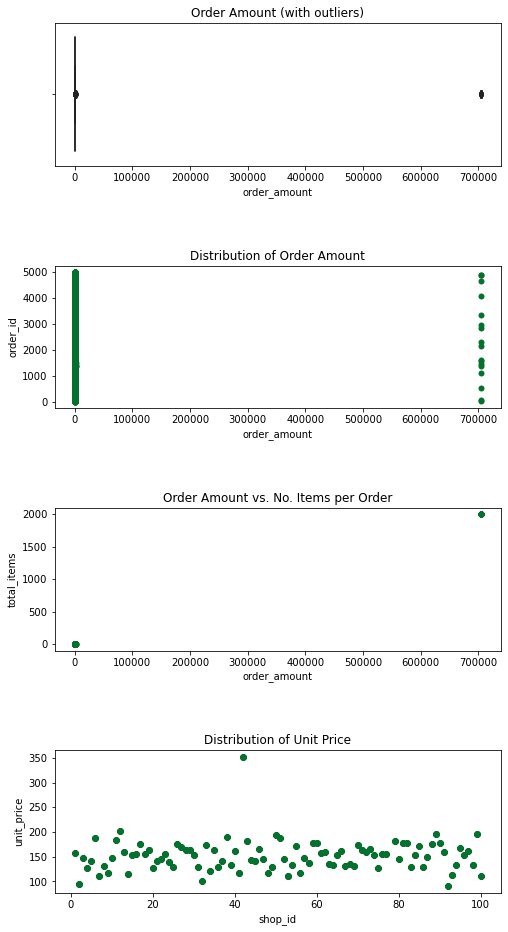

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(8,16))
plt.subplots_adjust(hspace=0.7)

# Order Amount Boxplot
sns.boxplot(x='order_amount', data=df_2, ax=axs[0]).set(title='Order Amount (with outliers)')

# Order Amount Scatterplot
sns.scatterplot(x='order_amount', y='order_id', data=df_2, linewidth=0, 
                ax=axs[1]).set(title='Distribution of Order Amount')

# Total Items Scatterplots
sns.scatterplot(x='order_amount', y='total_items', data=df_2, linewidth=0, 
                ax=axs[2]).set(title='Order Amount vs. No. Items per Order')

# Shop Id Scatterplots
sns.scatterplot(x='shop_id', y='unit_price', data=df_2, linewidth=0, 
               ax=axs[3]).set(title='Distribution of Unit Price')

We can see that the group of outliers with order amounts of ~10,000-100,000 has been removed, meaning they were due to Shop 78. Reviewing the plots, it is clear that we still have two issues to deal with: (1) The orders with ~2000 items resulting in order values of 700,000+; (2) The shop with the unit price of ~350, which is much more apparent as an outlier now that Shop 78 has been removed.

Let's go ahead and remove the shop with a unit price of ~350.

In [11]:
# Find Shop IDs where unit price is > $300
outlier_shops = df_2[df_2.unit_price > 300]['shop_id'].unique()
print('IDs of shops with a unit price > $300:', outlier_shops)

IDs of shops with a unit price > $300: [42]


We have one shop (Id=42) where the unit price is > 300. Before removing this shop from the data set, let's get some information on it to report in our summary (number of orders and average/min/max total number of items per order).

In [12]:
# Count number of orders from Shop 42
orders42 = (df_2.shop_id == 42).sum()
print('Number of orders from Shop 42:', orders42)

Number of orders from Shop 42: 51


In [13]:
# Get average, min, and max total number of items per order from Shop 78
min42 = df_2.loc[df_2['shop_id']==42, 'total_items'].min()
max42 = df_2.loc[df_2['shop_id']==42, 'total_items'].max()
mean42 = df_2.loc[df_2['shop_id']==42, 'total_items'].mean()
print('Minimum number of items per order from Shop 42:', min42)
print('Maximum number of items per order from Shop 42:', max42)
print('Average number of items per order from Shop 42:', mean42)

Minimum number of items per order from Shop 42: 1
Maximum number of items per order from Shop 42: 2000
Average number of items per order from Shop 42: 667.9019607843137


It looks like we've fed two birds with one scone! Not only does Shop 42 have an outlier unit price, it is also the culprit begind the orders of 2000 items equally 700,000+. Let's find out how many orders have totals over 700,000 and then find the min/max/average number of items for the remaining orders so we can report these values in our summary.

In [14]:
# Find number of orders from Shop 42 with order value > $700,000
df_2.loc[(df_2['shop_id']==42) & (df_2['order_amount']>700000)].shape[0]

17

In [15]:
# Create df with just Shop 42 orders < $700,000 and get average, min, and max number of items per order
df_42 = df_2.loc[(df_2['shop_id']==42) & (df_2['order_amount']<700000)]

min42 = df_42['total_items'].min()
max42 = df_42['total_items'].max()
mean42 = df_42['total_items'].mean()
print('Minimum number of items per order from Shop 42:', min42)
print('Maximum number of items per order from Shop 42:', max42)
print('Average number of items per order from Shop 42:', mean42)

Minimum number of items per order from Shop 42: 1
Maximum number of items per order from Shop 42: 5
Average number of items per order from Shop 42: 1.8529411764705883


Let's go ahead and remove Shop 42 from our data set and look at our visualizations again. 

In [16]:
# Create copy of df_2 without orders from Shop 42
df_3 = df_2.drop(df_2[df_2.shop_id == 42].index)

# Check the shape of the new data set to double check that only 17 rows were dropped (4954-51 = 4903)
df_3.shape[0]

4903

[Text(0.5, 1.0, 'Distribution of Unit Price')]

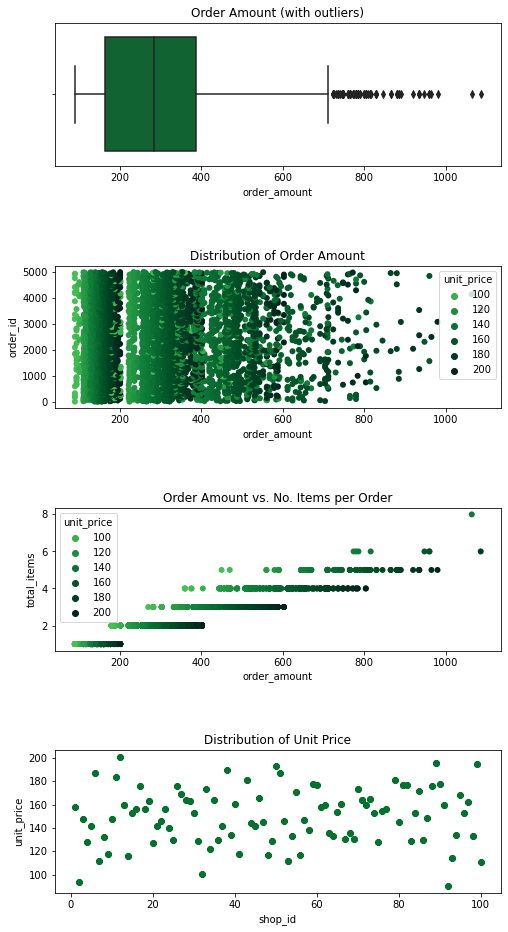

In [17]:
fig, axs = plt.subplots(4, 1, figsize=(8,16))
plt.subplots_adjust(hspace=0.7)

# Order Amount Boxplot
sns.boxplot(x='order_amount', data=df_3, ax=axs[0]).set(title='Order Amount (with outliers)')

# Order Amount Scatterplot
sns.scatterplot(x='order_amount', y='order_id', data=df_3, linewidth=0, hue='unit_price', palette=cmap,
                ax=axs[1]).set(title='Distribution of Order Amount')

# Total Items Scatterplots
sns.scatterplot(x='order_amount', y='total_items', data=df_3, linewidth=0, hue='unit_price', palette=cmap,
                ax=axs[2]).set(title='Order Amount vs. No. Items per Order')

# Shop Id Scatterplots
sns.scatterplot(x='shop_id', y='unit_price', data=df_3, linewidth=0,
               ax=axs[3]).set(title='Distribution of Unit Price')

Our data is looking much more consistent and evenly distributed now that we've removed Shop 42. Before we evaluate our final data set, let's make sure that we didn't lose too much information. We started with 100 shops and 5000 data points. After removing Shops 78 & 42, we are left with 98 shops and 4903 data points. Overall, we cut 2% of our data and were left with 98%. I would say that is still a reasonable amount of data to work with and the two shops that were dropped can be reported as special cases. 

#### Review of Clean Data
The metrics we are looking for (average order value, order value range, average number of items per order, and range of number of items per order) can all be taken from the statistical summary of our clean data set using *`.describe()`*. 

In [18]:
df_3.describe()

order_id      shop_id      user_id  order_amount  total_items  \
count  4903.000000  4903.000000  4903.000000   4903.000000  4903.000000   
mean   2499.584540    49.900877   849.858862    300.155823     1.995717   
std    1444.221163    29.154367    86.887947    155.941112     0.982602   
min       1.000000     1.000000   700.000000     90.000000     1.000000   
25%    1246.500000    24.000000   776.000000    163.000000     1.000000   
50%    2499.000000    50.000000   850.000000    284.000000     2.000000   
75%    3750.500000    74.000000   925.000000    386.500000     3.000000   
max    5000.000000   100.000000   999.000000   1086.000000     8.000000   

        unit_price  
count  4903.000000  
mean    150.400163  
std      23.851202  
min      90.000000  
25%     132.000000  
50%     153.000000  
75%     166.000000  
max     201.000000

***
## Question 2
For this question you’ll need to use SQL. __[Follow this link](https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL)__ to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

1. How many orders were shipped by Speedy Express in total?
1. What is the last name of the employee with the most orders?
1. What product was ordered the most by customers in Germany?
